In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import linalg

from tutorial_utils import reliability_diagram, get_mvn_cdf, example_fit_and_predict

/home/kleeman/miniconda3/envs/dev/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Evaluating a Model Using Noisy Evaluation Data

The goal of this tutorial is to illustrate some of the challenges of evaluating a model. You may be evaluating a model using an explict (held out) evaluation dataset, or potentially looking at in sample measurement residuals. In either case you'll be dealing with noisy, potentially biased data and will need to think carefully about how you handle the uncertainty estimates and any remaining biases.

A few of the key points are:

### If the evaluation data is biased:
- You need to remove (or account for) bias before evaluating.
- The method you use to remove bias will affect the residual distribution.
- If you manipulate the evaluation data, you also need to manipulate covariance estimates.
- If you manipulate covariance estimates you need to keep track of remaining degrees of freedom.

### If either the model's variance _or_ evaluation data's measurement noise is non-uniform:
- You need to weight measurements differently when you de-bias your evaluation data.
- You (probably) want to use robust measures of error (median absolute error) not RMSE

# Errors and Residuals

Consider the situation where you have some measurements, $y_i$, corresponding to some meta data, $x_i$, and a model which has attempted to predict the values of the measurements, $\hat{y}_i = \mbox{model}(x_i)$. We can comute the difference between the actual measurements and model's prediction of the measurements to get.
$$
y_i - \hat{y}_i
$$

When the measurements, $y_i$ were already used to train the model (in sample) the result is often called a residual,
$$
r_i = y_i - \hat{y}_i
$$
When the measurements were _not_ used to train the model (out of sample) the result is often called an error,
$$
e_i = y_i - \hat{y}_i
$$
sometimes it's not quite so black and white. You might, for example, have measurements which were not directly used in the model, but are highly correlated measurements which were. For the rest of the tutorial we'll refer to residuals, but those could be errors, or somewhere in the gray area inbetween.

### Example Problem

Let's assume we're dealing with multi-dimensional data (so $y = \left\{y_0, \ldots, y_n\right\}$) and the measurements (and residuals) may be correlated.

For example, maybe $y$ represents a series of hourly temperature measurements, $x_i$ would be the hour corresponding to $y_i$. If the measurements are close enough in time they might be correlated, so the residuals may also be correlated.

We can simulate a situation like this by creating a random covariance $\Sigma$ and then drawing random samples from it which can serve is simulated correlated residuals,
$$
r \sim \mathcal{N}\left(0, \Sigma\right)
$$

('', (-3.0, 3.0))

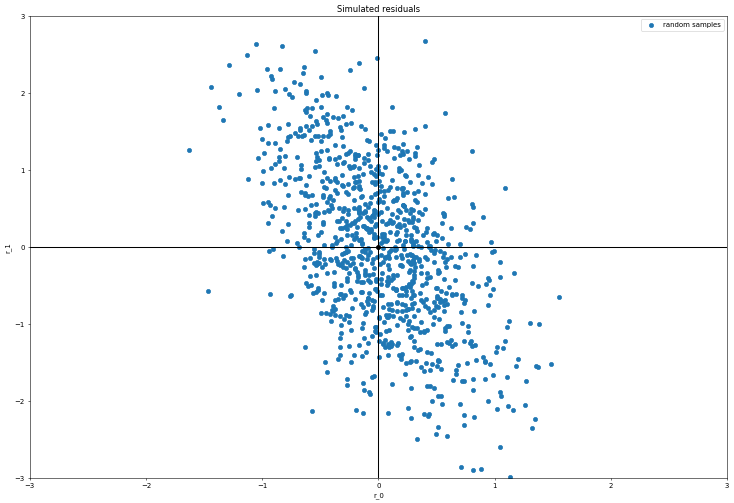

In [2]:
MEAS_NOISE = 1e-2
def random_covariance(n, meas_noise=MEAS_NOISE):
    # make a random orthonormal matrix
    Q, _ = np.linalg.qr(np.random.normal(size=(n, n)))
    # then random "eigen values"
    V = np.random.gamma(shape=1., size=n)
    # and add a little bit of measurement noise,
    noise = meas_noise * meas_noise * np.eye(n)
    return Q @ np.diag(V) @ Q.T + noise


def random_samples(cov, k=1000):
    # returns an (n, k) matrix with random samples such that each
    # column is a sample from N(0, cov)
    return np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=k).T

S = random_covariance(2)
samples = random_samples(S, 1000)
plt.scatter(samples[0, :], samples[1, :], label="random samples")
plt.scatter(0, 0, color="black")
plt.plot([-5, 5], [0, 0], color='black')
plt.plot([0, 0], [-5, 5], color='black')
plt.ylabel("r_1")
plt.xlabel("r_0")
plt.title("Simulated residuals")
plt.legend()
plt.xlim([-3, 3])
_, plt.ylim([-3, 3])

Each point is a randomly generated $r$. The x axis shows $r_0$ for each sample, the y axis shows $r_1$. The scale is fixed there, so if you evaluate it repeatedly you'll see different random distributions.

# Summary Statistics
During model evaluation we'd often like to compute some measure of the size of the residuals, probably something like the root mean squared error which (assuming $r \in \mathbb{R}^{n}$ is a vector) could be computed using,
$$
\mbox{rmse}(r) = \sqrt{\frac{1}{n} r^T r}
$$
or perhaps mean absolute error,
$$
\mbox{mae}(r) = \frac{1}{n}\sum_i |r_i|
$$
using the simulated values above we can look at the distribution of expected RMSEs,

Text(0.5, 1.0, 'Simulated Root Mean Squared Errors')

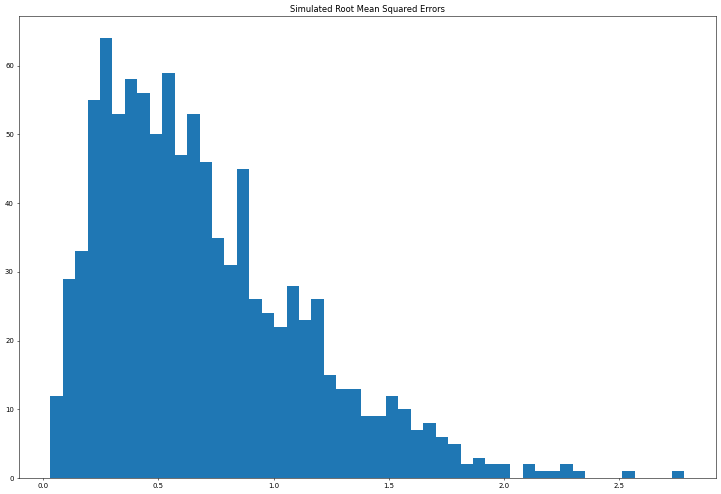

In [3]:
def rmse(x):
    return np.sqrt(np.mean(np.square(x), axis=0))

plt.hist(rmse(samples), bins=51)
plt.title("Simulated Root Mean Squared Errors")

The root mean squared error is a popular choice for measuring accuracy of a model because _under the assumption the residuals are unbiased_ the expected RMSE should tend towards zero when the model makes perfect predictions. In practice however, there may be reasons you'd never expect the RMSE to approach zero. If the residuals are computed using measurements and those measurements have measurement noise, then even a "perfect" model will not be able to know the measurement noise for an out of sample measurement. Similarly, there may be other unmodelable quantities which would prevent the RMSE from approaching zero.

# Unmodeled Errors

Consider the case were you've built a model and are trying to evaluate it, it's entirely possible there are sources of error in the evaluation data which are impossible for the model to predict. You'll probably want to remove these errors from your evaluation metrics so they aren't misleading.

As an example, let's say we're trying to model temperature at some location over a period of time. Maybe we've trained this model using data from a number of thermometers, and then plan on evaluating the model using a previously unobserved thermometer. What if the evaluation thermometer is biased? Perhaps it wasn't calibrated well. If that were the case then even a perect temperature model has no way of knowing the calibration bias for an out of sample thermometer. This calibration bias could be an example of an unmodelable bias.

Here's a visualization of what a calibration bias might look like,

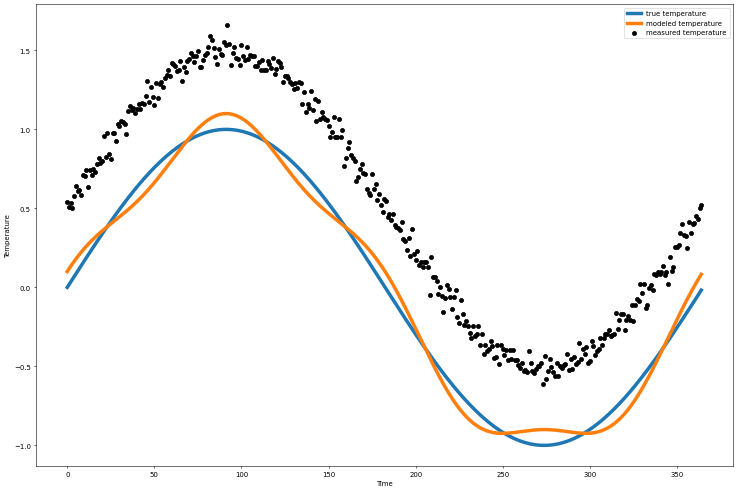

In [4]:
TEMPERATURE_MEAS_NOISE = 0.05
xs = np.arange(365)
seasonality = xs * (2 * np.pi / 365)
truth = np.sin(seasonality)
plt.plot(xs, truth, label="true temperature", lw=5)
modeled = truth + 0.1 * np.cos(seasonality * 4)
plt.plot(xs, modeled, label="modeled temperature", lw=5)
measurements = truth + 0.5 + TEMPERATURE_MEAS_NOISE * np.random.normal(size=truth.size)
plt.scatter(xs, measurements, label="measured temperature", color='black')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()

If we were to directly compute the residuals we'd see a very obvious bias:

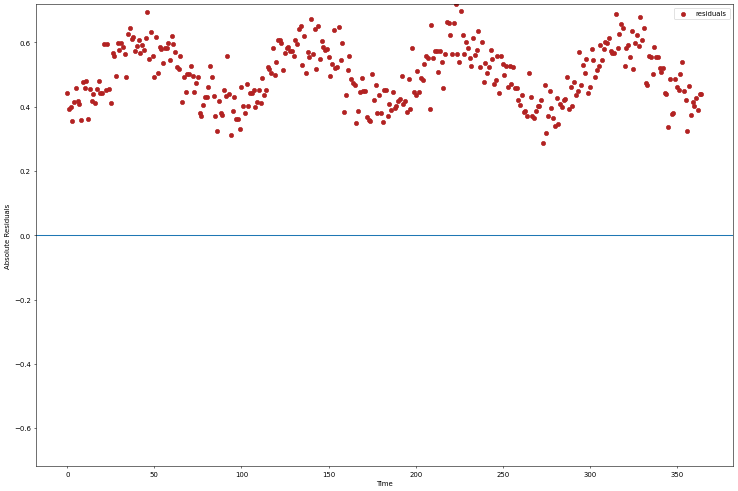

In [5]:
residuals = measurements - modeled
plt.scatter(xs, residuals, label="residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Absolute Residuals")
plt.xlabel("Time")
plt.legend()

In this case we probably don't actually care about the raw residuals, $r = y - \hat{y}$ since we know it's contaminated by something unmodelable. Instead we might want to allow for a constant offset. There are (at least) two ways this could be accomplished. You can imagine removing the mean residual, which we'll call "debiasing",

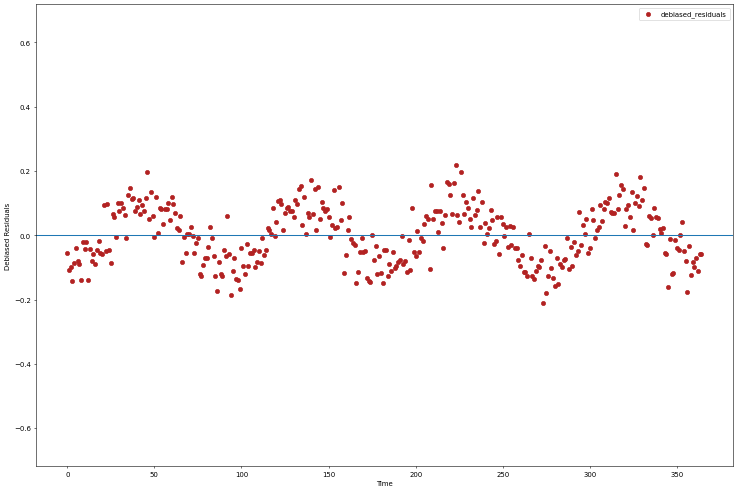

In [6]:
plt.scatter(xs, residuals - np.mean(residuals), label="debiased_residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Debiased Residuals")
plt.xlabel("Time")
plt.legend()

Here we estimate the mean, then remove it from all observations resulting in residuals under a constant bias assumption. But another technique which is relatively common in some domains is to compute the difference between residuals. To do so you'd need to pick a reference and subtract it from all other elements,

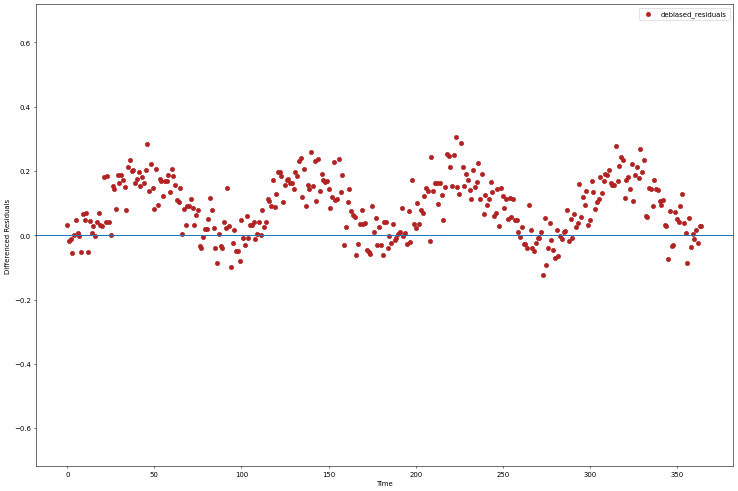

In [7]:
plt.scatter(xs, residuals - residuals[25], label="debiased_residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Differenced Residuals")
plt.xlabel("Time")
plt.legend()

Assuming the unmodelled bias was the same on all residuals, then differencing will cancel the bias. Indeed the plots of debiasing and differencing look nearly identical.

Here are the RMSEs we would get using these two different approaches (debiasing and differencing):

In [8]:
print("RMSE[debias]", rmse(residuals - np.mean(residuals)))
print("RMSE[differencing]", rmse(residuals - residuals[25]))

RMSE[debias] 0.08726804579589341
RMSE[differencing] 0.12350667874588885


Both methods remove the bias, but notice that the two approaches are NOT the same! As you can imagine, the differenced RMSE will be sensitive to the choice of reference.

# Simulations With Bias

Let's generate some more simulations with biases to explore the pros/cons of these two approaches for measuring residuals in the presence of a bias. To do so, we'll build a random covariance matrix $\Sigma$ (which we'll call `S` in the code). Then we can also randomly generate a bias. We'll simulate a sample by randomly drawing from a Gaussian with the prescribed covariance, then adding in the random bias.

(-5.0, 5.0)

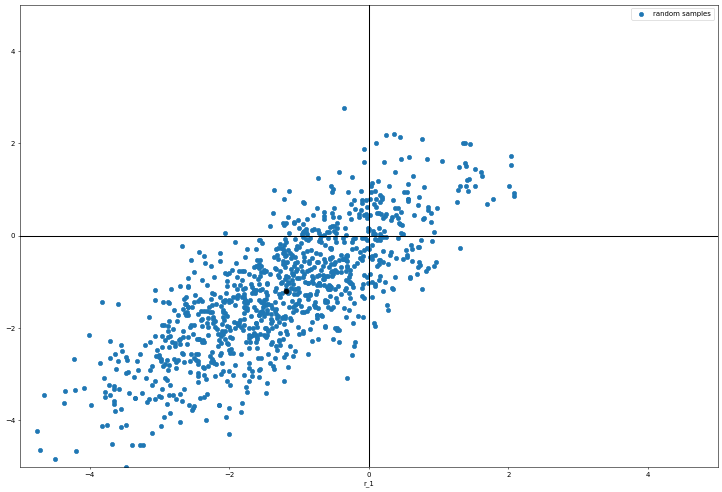

In [9]:
S = random_covariance(2)
bias = np.random.normal(size=1)
samples = random_samples(S, 1000) + bias
plt.scatter(samples[0, :], samples[1, :], label="random samples")
plt.scatter(bias, bias, color="black", s=50)
plt.plot([-5, 5], [0, 0], color='black')
plt.plot([0, 0], [-5, 5], color='black')
plt.xlabel("r_0")
plt.xlabel("r_1")
plt.legend()
plt.xlim([-5, 5])
plt.ylim([-5, 5])

If you re-evaluate the previous cell enough you should see that we now have random samples which are all offset by another random value. For our simulation we'll repeat that process using a fixed $\Sigma$ and bias, but using a large number of random samples from $\mathcal{N}(0, \Sigma)$. (We've kept the bias fixed here to make it easy to remove the known bias in the examples below)

In [10]:
def random_simulation_fixed_bias(n=100, k=1000):
    S = random_covariance(n)
    bias = np.random.normal(size=1)
    r = random_samples(S, k) + bias
    return S, bias, r

Now, we can make some operators which do the equivalent of removing a mean, or picking a reference. First consider the differencing operator,
$$
D = \begin{bmatrix}
1 & 0 & \cdots & 0 & -1 \\
0 & 1 & \cdots & 0 & -1 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & -1 \\
    \end{bmatrix}
$$
The result of this operator will be a new vector, $D r \in \mathbb{R}^{n-1}$ with elements corresponding to having subtracted off the last (reference) residual $\left[Dr\right]_i = r_i - r_n$

In [11]:
def diff_operator(n):
    # return an (n-1, n) matrix in the form:
    #
    #   [1 0 ... 0 -1]
    #   [0 1 ... 0 -1]
    #   [0 0 ... 1 -1]
    #
    # which represents using the last element as reference
    # in a differencing operation.
    D = np.eye(n-1, n)
    D[:, -1] = -1
    return D

Similarly we can form a debias operator which removes the mean value. This operator will look something like,
$$
B = I - \frac{1}{n} \mathbb{1}^{n, n}
$$
The result will be a new vector $B r \in \mathbb{R}^{n}$ with elements corresponding to having subtracted off the mean residual $\left[Br\right]_i = r_i - \frac{1}{n}\sum_j r_j$.

In [12]:
def debias_operator(n):
    # return an (n, n) matrix in the form:
    #
    #   [1-a   -a ... -a]
    #   [-a   1-a ... -a]
    #   [-a   -a  ... 1-a]
    #
    # which represents solving for a bias, b, which solves
    # the least squares solution to,
    #
    #   y = A x
    #
    # with A and x looking like
    #
    #       |1
    #   y = |1  x
    #       |.
    #       |1
    return np.eye(n) - (1.0 / n) * np.ones((n, n))

Let's use these operators to compute the RMSE of residuals for a large number of random simulations. Because it's a simulation we know the bias we've added to the residuals, so we can compute the "actual" (uncontaminated) residuals and compare the RMSE we'd get with debiasing or differencing to the residuals we would have gotten if the truth were not biased.

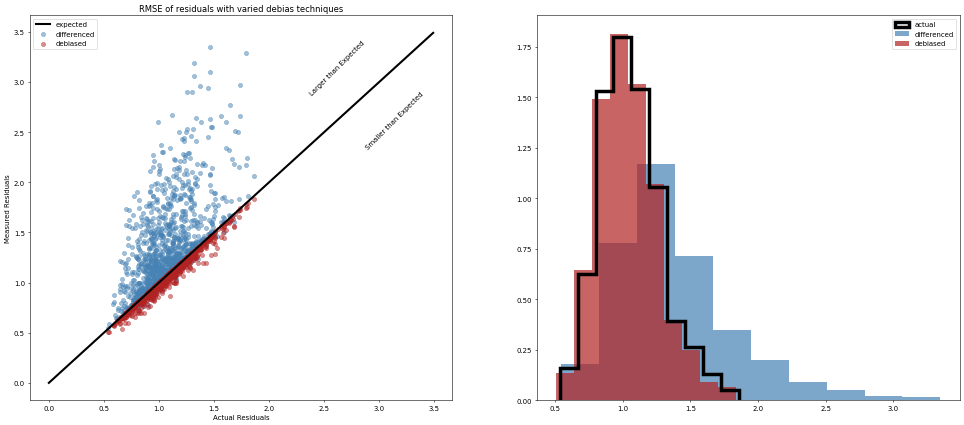

In [13]:
def compare_rmses(residuals, known_bias, label=None):
    D = diff_operator(S.shape[0])
    diff_residuals = D @ residuals
    diff_rmses = rmse(diff_residuals)

    B = debias_operator(S.shape[0])
    debias_residuals = B @ residuals
    debias_rmses = rmse(debias_residuals)

    actual_rmses = rmse(r - known_bias)

    fig, axes = plt.subplots(1, 2, figsize=(24, 10))

    axes[0].scatter(actual_rmses, diff_rmses, color='steelblue',
                    alpha=0.5, label="differenced")
    axes[0].scatter(actual_rmses, debias_rmses, color='firebrick',
                    alpha=0.5, label="debiased")
    ylim = max(axes[0].get_ylim())
    axes[0].plot([0, ylim], [0, ylim], color='black', lw=3, label="expected")
    axes[0].set_xlabel("Actual Residuals")
    axes[0].set_ylabel("Measured Residuals")
    axes[0].legend()
    axes[0].set_title("RMSE of residuals with varied debias techniques")

    axes[0].text(0.75 * ylim, 0.9 * ylim, "Larger than Expected",
                 horizontalalignment="center",
                 verticalalignment="center",
                 rotation=45)
    axes[0].text(0.9 * ylim, 0.75 * ylim, "Smaller than Expected",
                 horizontalalignment="center",
                 verticalalignment="center",
                 rotation=45)
    axes[1].hist(actual_rmses, color='black', label="actual",
                 histtype='step', density=True, lw=5)
    axes[1].hist(diff_rmses, color='steelblue', label="differenced",
                 density=True, alpha=0.7)
    axes[1].hist(debias_rmses, color='firebrick', label="debiased",
                 density=True, alpha=0.7)
    axes[1].legend()

S, bias, r = random_simulation_fixed_bias(n=20, k=1000)
compare_rmses(r, bias)

The differenced residuals are typically larger than we'd expect while the debiased residuals are typically smaller! Looking at the histograms we see the debiased residuals align much more closely with the "actual" residuals (which were computed using the known bias).

Why? By differencing, any measurement noise from the reference measurement is going to get added into all the other residuals, which is then going to get squared before summing. Sometimes that aded measurement noise might actually cancel other noise, so you'll occasionally see some differenced residuals which are smaller than expected, but typically that added noise will increase residuals.

On the contrary, when you debias some of the measurement noise is going to influence your estimate of the bias, so when the bias is removed from the measurements it'll also be removing the average measurement noise, making the RMSE values smaller. This phenomena diminishes with more observations (more observations means it's more likely the average noise is zero). With differencing the pheonoema persists, here's the same plot when you increase the number of measurements in each sample,

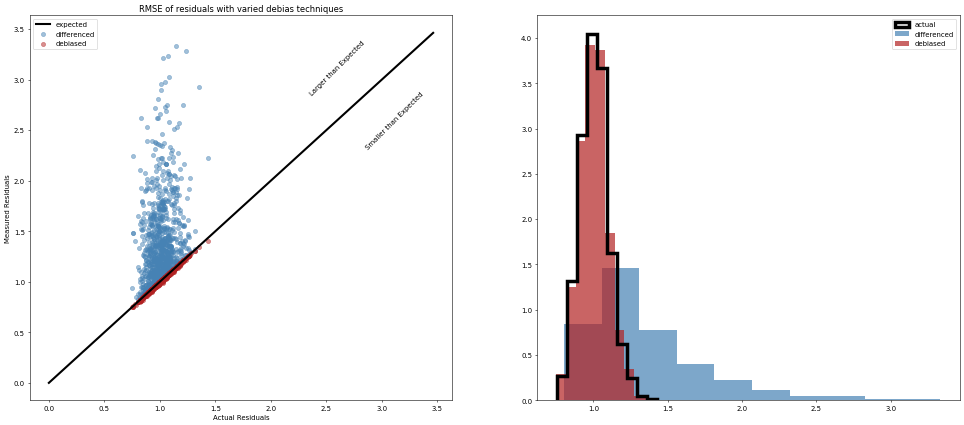

In [14]:
S, bias, r = random_simulation_fixed_bias(n=100, k=1000)
compare_rmses(r, bias)

The key point here: in the limit (so as you include more measurements in your residual computations) the RMSE you'd compute using a debiasing technique will approach the RMSE you'd get if you'd known the actual bias. If you're differencing that will not be the case, your RMSE computed when differencing will always be heavily influenced by a single measurement's noise.

### Key Points
- If the evaluation data is biased, you'll need to remove (or account for that bias) before evaluating.
- The method you use to remove bias will affect the residual distribution.

# Reliability Diagrams from Residuals

Let's continue to consider the situation in which we're provided data which is tainted by a bias. Now we'd like to ask a question along the lines of "Is $\Sigma$ a reliable covariance estimate for the data". Perhaps $\Sigma $ is the predictive distribution from your model and you'd like to know if it's reliable, or perhaps it's a prior you've placed on the evaluation data (ie, measurement noise etc ...) and you'd like to know if there are any other unexpected error sources present in the data. In either case you may want to be looking at the reliability diagrams we described in Tutorial 5.

If you look at the simulation above you'll see that we first generated an example covariance, $\Sigma$, drew samples from $\mathcal{N}\left(0, \Sigma\right)$ and **then** added in a bias. So the bias will not be reflected in $\Sigma$. We can confirm this by plotting the reliability diagram using the samples, $r$, and the covariance, $\Sigma$,

In [15]:
SIGMA_BIAS = np.log(2)
def random_simulation(n=100, k=1000):
    S = random_covariance(n)
    bias = np.random.normal(size=k) * SIGMA_BIAS
    r = random_samples(S, k) + bias
    return S, r

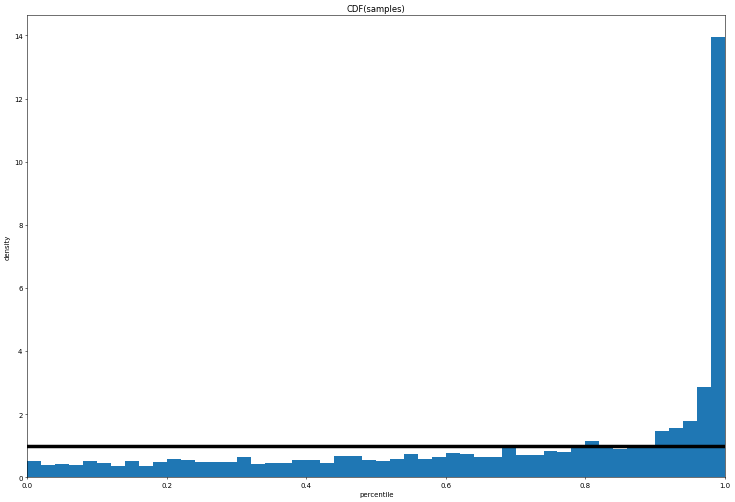

In [16]:
S, r = random_simulation(n=10, k=5000)
reliability_diagram(r, get_mvn_cdf(S))

Almost all the chi squared percentiles are piled up around $1$ indicating most of the data falls in the tails of $\mathcal{N}\left(0, \Sigma\right)$. We'd expect these percentiles to be uniformly distributed and they definitely are not, which is telling us loud and clear that something is wrong.

You can think of these reliability tests as a way of answering the question "Does the model describe the data". In this case the model $\Sigma$ does not describe the data, $r$, because the bias is unaccounted for. We'll need to change the question we're asking to "Does the model describe the data after accounting for an unknown bias". This gives us two options:

1) Remove the bias, then evaluate reliability.
2) Account for the bias in the covariance, then evaluate reliability.

## Option 1: Removing The Bias, Then Evaluating Uncertainty

### Using the Difference Operator

First we'll show how to remove the bias, then evaluate reliablity. Above we built a differencing operator, $D$, and we showed that we can apply the operator to get unbiased residuals. We can re-use that operator to evaluate reliability, but we'll also need to apply it to the covariance. Starting with a biased description of the random samples, $r$,
$$
\mathbf{r} \sim \mathcal{N}(b \mathbb{1}, \Sigma)
$$
we can apply the operator to get the differenced distribution,
$$
D \mathbf{r} \sim \mathcal{N}(0, D \Sigma D^T)
$$
Now let's compute the reliability diagram after having applied the operator to both data and covariance,

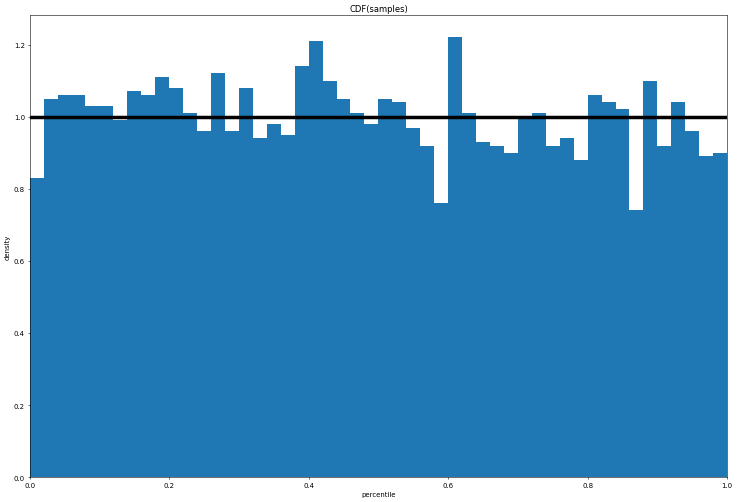

In [17]:
S, r = random_simulation(n=10, k=5000)

B_diff = diff_operator(S.shape[0])
diff_residuals = B_diff @ r
diff_cov = B_diff @ S @ B_diff.T

reliability_diagram(diff_residuals, get_mvn_cdf(diff_cov))

Looks pretty uniform!

### Using the Debias Operator

Now instead of the differencing operator, let's do the same thing with the debias operator,

In [18]:
B_diff

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

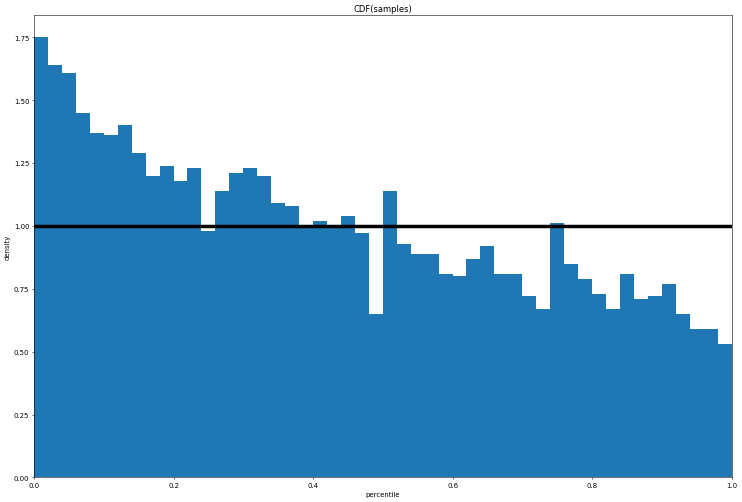

In [19]:
B_debias = debias_operator(S.shape[0])

debias_residuals = B_debias @ r
debias_cov = B_debias @ S @ B_debias.T

reliability_diagram(debias_residuals, get_mvn_cdf(debias_cov))

Uh Oh. The result shoudln't look perfectly uniform. Why? Check out the sizes of the operators for the two approaches:

In [20]:
print("Difference", B_diff.shape)
print("Debias", B_debias.shape)

Difference (9, 10)
Debias (10, 10)


The difference operator removes a dimension, the debias operator does not. So when we compute the normalized sum square error while differencing we assume it's chi squared distributed with $n-1$ degrees of freedom, but when we do the same for the debias approach we're using $n$ degrees of freedom. Here's the reliability diagram for the debias approach (again) but this time with one fewer degrees of freedom:

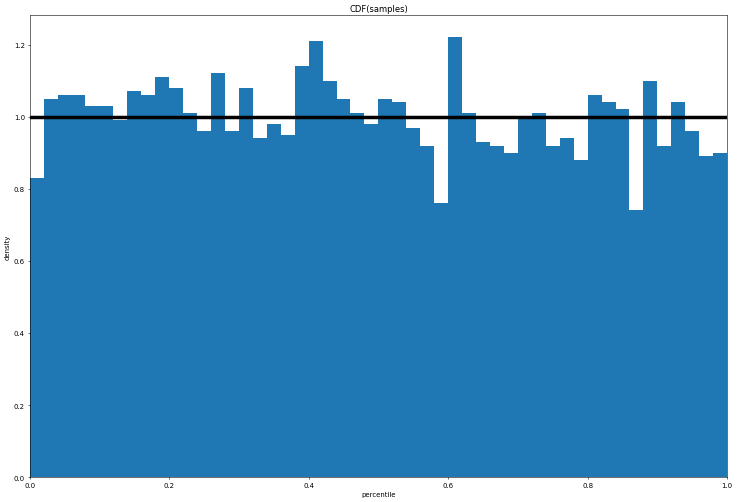

In [21]:
debias_df = debias_cov.shape[0] - 1
reliability_diagram(debias_residuals, get_mvn_cdf(debias_cov, df=debias_df))

Much better. So if we're using the debias operator we need to remove a degree of freedom. But more generally we'll need to compute the effective degrees of freedom.

### Key Point: If you're applying an operator to the covariance before evaluating it you need to carefully keep track of degrees of freedom

### Computing the Degrees of Freedom

Above the debias operator was hard coded specifically such that the resulting residuals will have had the mean value removed $r_i = r_i - \frac{1}{n} \sum_j^n r_j$. Another way to think about this is that we're estimating a single offset, $x = [\frac{1}{n} \sum_j^n r_j]$, which can be applied to equally to all values, $\mu = \mathbb{1} x$. Here $\mathbb{1}$ is a column vector of all ones and we're subsequently claiming that $r \sim  \mathcal{N}\left(\mu, \Sigma\right)$.

This can be framed as a least squares problem. We can say that we'd like to estimate a term, $x$, which is shared with all residuals. We can write this,
$$
\mu = A x
$$
with
$$
A = \begin{bmatrix}
1 \\ \vdots \\ 1
\end{bmatrix}
$$
and
$$
x = \begin{bmatrix} \mbox{bias} \end{bmatrix}
$$
In the single bias case we are able to solve for $x = [\frac{1}{n} \sum_j^n r_j]$ directly, but more generally we can find the least squares solution for $x$ using the normal equations,
$$
x = \left(A^T A\right)^{-1} A^T r
$$
and because that represents our bias, we can then remove it from the residuals,
$$
\begin{align}
\hat{r} &= r - A x \\
&= r - A \left(A^T A\right)^{-1} A^T r \\
&= r - H r \\
&= \left(I - H\right) r
\end{align}
$$
This results in some unfortunate vocabulary. We started with residuals, then we're building a model and removing modeled terms from the residuals so is $\hat{r}$ the residuals from residuals??

The $H = A \left(A^T A\right)^{-1} A^T$ term is often called the "hat operator" and it has some cool properties (which I've stolen from [here](https://stats.stackexchange.com/a/24941)). First, $H$ is symmetric, so $H = H^T$. Also $H$ is idempotent, so applying it once is the same as applying it repeatedly $H H = H$. For this to hold that means that $H$ must have eigen values which are either zero or one and we can take advantage of that to determine how many degrees of freedom are being removed when we apply these operators. Here is the hat operator for our debiasing example,

In [22]:
def hat_operator(A):
    # H = A (A^T A)^-1 A^T
    return A @ np.linalg.solve(A.T @ A, A.T)

n = S.shape[0]
A_debias = np.ones((n, 1))
H_debias = hat_operator(A_debias)
print("Least Squares Operator: \n", A_debias)
print("Hat Operator: \n", H_debias)
print("Eigenvalues: \n", np.round(np.abs(np.linalg.eigvals(H_debias)), 12))

Least Squares Operator: 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
Hat Operator: 
 [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
Eigenvalues: 
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


From this we see that there is one non-zero eigen value, so we must be removing one degree of freedom. We can use the hat operator to form the debiasing operator ($B = I - H$), and we can count the number of degrees of freedom by summing the eigen values of $B$ (which is conveniently [equivalent to the trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)#Trace_as_the_sum_of_eigenvalues)).

In [23]:
def debias_operator_alternate(n):
    A = np.ones((n, 1))
    return np.eye(n) - hat_operator(A)

print("Via Least Squares\n", debias_operator_alternate(4))
print("Hardcoded\n", debias_operator(4))
print("Degrees of Freedom : ", np.trace(debias_operator(4)))

Via Least Squares
 [[ 0.75 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25  0.75 -0.25]
 [-0.25 -0.25 -0.25  0.75]]
Hardcoded
 [[ 0.75 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25  0.75 -0.25]
 [-0.25 -0.25 -0.25  0.75]]
Degrees of Freedom :  3.0


We now have the tools to start with a proposed residual distribution, $r \sim \mathcal{N}(\mu, \Sigma)$, from which we'd like to remove some unmodelable terms. We can describe the terms we'd like to remove using a least squares approach, $A$, use $A$ to remove the unmodeled terms, and manipulate the covariance in a way which let's us still test the reliability of the original uncertainty estimate.

## Option 2: Accounting for Bias in the Covariance

Above we said there were (at least) two ways to evaluate the reliability given biased measurements. We've seen how you can compute reliability by forming a residual operator and applying it to both the measurements and covariance. Here we describe an alternative in which you add in the covariance of the unmodelled terms.

Going back to the section on computing degrees of freedom using a least squares operator, $A$, we solved for $\hat{x} = \left(A^T A\right)^{1-} A^T r$, then computed $\hat{r} = r - A \hat{x}$.

Instead of estimating and removing $x$ we can instead place a prior on the state, $x$,
$$
x \sim \mathcal{N}\left(0, C \right)
$$
and use that to compute the prior covariance for $A x$,
$$
\begin{align}
A x & \sim A \mathcal{N}\left(0, C \right) \\
& \sim \mathcal{N}\left(0, A C A^T \right)
\end{align}
$$
Then we can add the model and bias covariances together,
$$
r \sim \mathcal{N}\left(0, S + A C A^T\right).
$$
In our simulation we applied a common bias to all variables, so $x$ is one dimension,
$$
x \sim \mathcal{N}\left(0, \begin{bmatrix} \sigma_x^2 \end{bmatrix} \right)
$$
and use that to compute the prior covariance for $A x$,
$$
\begin{align}
A x & \sim \mathcal{N}\left(0, \mathbb{1} \begin{bmatrix} \sigma_x^2 \end{bmatrix} \mathbb{1}^T \right) \\
& \sim \mathcal{N}\left(0, \sigma_x^2 \mathbb{1} \mathbb{1}^T \right) \\
\end{align}
$$

Now we can evaluate the reliablity:

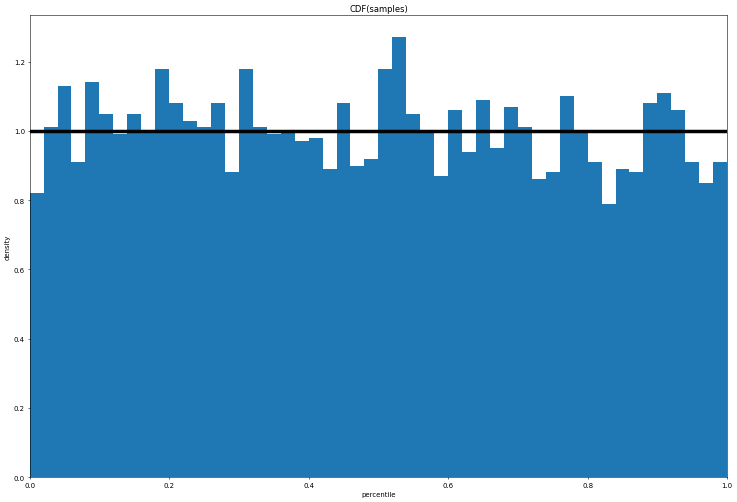

In [24]:
A_debias = np.ones((S.shape[0], 1))
bias_cov = SIGMA_BIAS * SIGMA_BIAS * A_debias @ A_debias.T
S_augmented = S + bias_cov
reliability_diagram(r, get_mvn_cdf(S_augmented))

That should look pretty uniform again which tells us this approach works too.

# Dealing with Non-Uniform Variance

Consider the temperature example from earlier, we plotted the difference between (uncalibrated) evaluation measurements and the model's estimates and saw there was a clear bias. Here's the same plot from earlier:

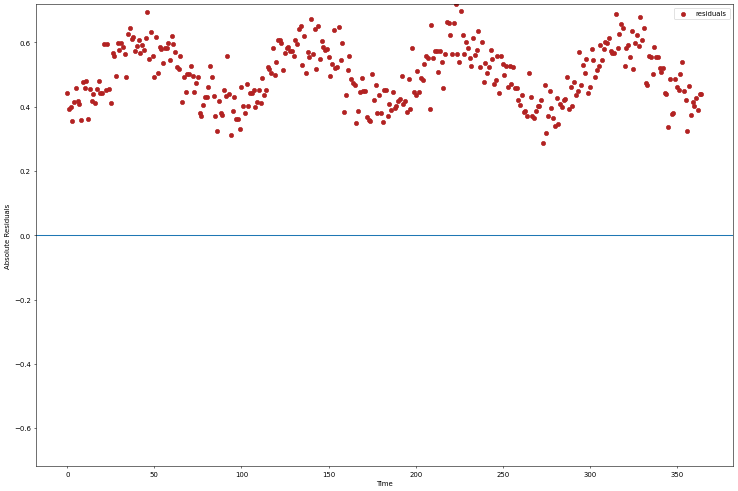

In [25]:
residuals = measurements - modeled
plt.scatter(xs, residuals, label="residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Absolute Residuals")
plt.xlabel("Time")
plt.legend()

Using the tools we've just described, we can build a debias operator via least squares,

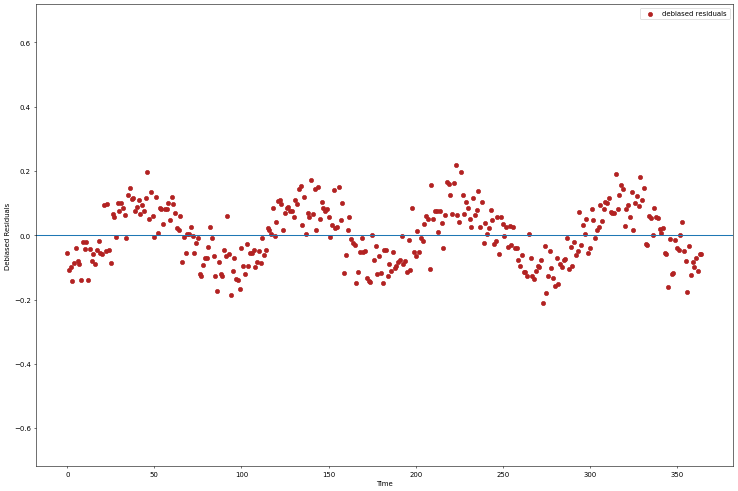

In [26]:
n = residuals.size
A = np.ones((n, 1))
B = np.eye(n) - hat_operator(A)
debiased = B @ residuals

plt.scatter(xs, debiased, label="debiased residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Debiased Residuals")
plt.xlabel("Time")
plt.legend()

Just visually we can see that we our debias operator, $B$, did infact remove the bias from the residuals. In this example each evaluation measurement had the same measurement noise _and_ we assumed the model's predicted variance for each time was the same. This debias operator was built assuming ordinary least squares (which assumes each measurement has the same variance).

Let's see what happens if this is not true. To do so we can further contaminate the evaluation data with difference variance. That variance will be different depending on the time. So we'll add a small amount of noise to most measurements, but then some very large noise to handful of the data points,

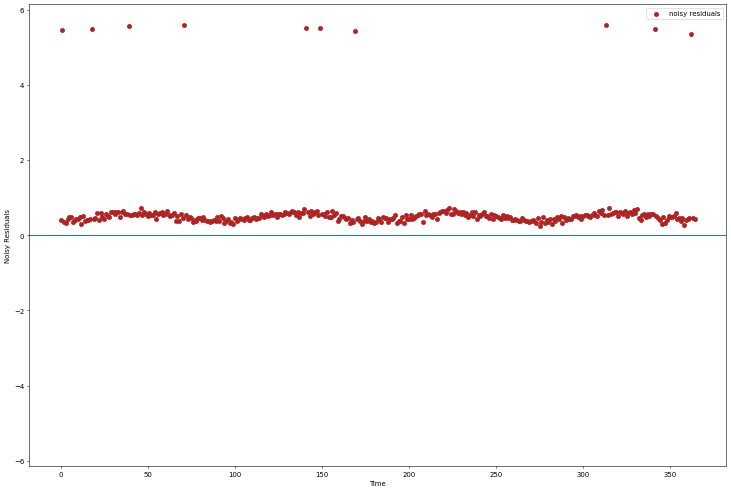

In [27]:
n = residuals.size
added_noise_cov = 0.001 * random_covariance(n)
noise = random_samples(added_noise_cov, 1)

# inflate the noise on one of the measurements
for i in np.arange(10):
    large_ind = np.random.randint(0, n- 1)
    large_sd = 5.
    added_noise_cov[large_ind, large_ind] += np.square(large_sd);
    # and make sure that residual has one standard deviation of err
    noise[large_ind] += large_sd;

noisy_residuals = residuals + noise.reshape(-1)

plt.scatter(xs, noisy_residuals, label="noisy residuals", color='firebrick')
lim = 1.1 * np.max(np.abs(noisy_residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Noisy Residuals")
plt.xlabel("Time")
plt.legend()

Now let's apply the same debias operator to this heteroskedastic (non-constant variance) data,

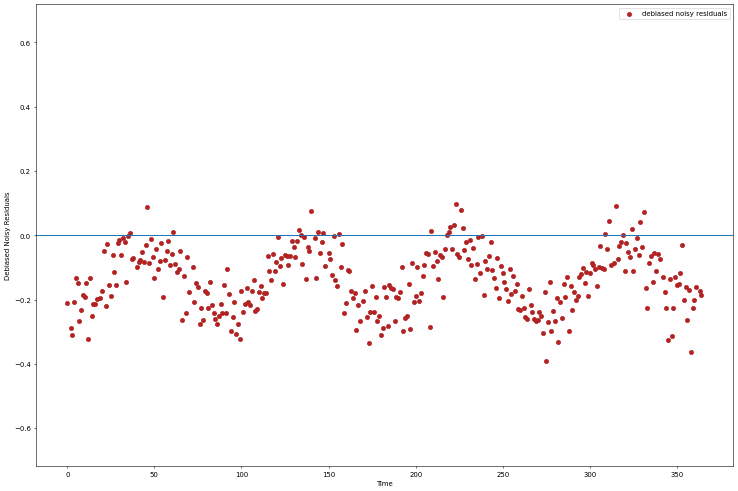

In [28]:
debiased_noisy = B @ noisy_residuals

plt.scatter(xs, debiased_noisy, label="debiased noisy residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Debiased Noisy Residuals")
plt.xlabel("Time")
plt.legend()

Even visually you can see that we did not properly remove the bias. The reason, of course, is that we built the linear operator to estimate the average error, which is then removed. That average error will be influenced by the extremely noisy data just as much as the low noise data, so the large measurement noise influences our estimate of the bias.

Instead of using ordinary least squares here, we might instead want to weight our estimate of the bias by the variance of the evaluation measurements. We designed the problem, so we know the noise, $Q$, this would make the residual distribution,
$$
\begin{align}
r &\sim \mathcal{N}\left(0, \Sigma + Q\right) \\
  &\sim \mathcal{N}\left(0, W^{-1}\right)
\end{align}
$$
Previously we wrote the observation bias, $\mu$ as a function of the bias state, $x$,
$$
\mu = A x
$$
To build our operator we need to estimate $\hat{x} = \left(A^T A\right)^{-1} A^T y$, then apply it to the observations to get $\hat{\mu}$. In this case we'd like to estimate $\hat{x}$ using weighted least squares to account for the variable uncertainty in the residuals. This leads to,
$$
\begin{align}
y &\sim \mathcal{N}\left(Ax, \Sigma + Q\right) \\
z &= W^{1/2} y \\
  &\sim \mathcal{N}\left(W^{1/2}Ax, W^{1/2} W^{-1} W^{1/2}\right) \\
  &\sim \mathcal{N}\left(W^{1/2}Ax, I\right)
\end{align}
$$
where here we started with a left hand side with correlated noise, and transformed it into a problem with independent identically distributed, $z$, which let's us solve for,
$$
\begin{align}
\hat{x} &= \left(A^T W^{T/2} W^{1/2}A\right)^{-1} A^T W^{T/2} W^{1/2} y \\
&= \left(A^T W A\right)^{-1} A^T W y \\
\end{align}
$$
Finally, we map those back to the observations to get a hat operator,
$$
H_{WLS} = A \left(A^T W A\right)^{-1} A^T W
$$

In [29]:
def weighted_hat_operator(A, cov):
    # Y = A (A^T W A)^-1 A^T
    # W = cov^-1
    Y = A @ np.linalg.solve(A.T @ np.linalg.solve(cov, A), A.T)
    # H = (W Y)^T
    return np.linalg.solve(cov, Y).T

n = residuals.size
simulated_cov = TEMPERATURE_MEAS_NOISE * TEMPERATURE_MEAS_NOISE * np.eye(n)
simulated_noisy_cov = simulated_cov + added_noise_cov
H_wls = weighted_hat_operator(A, simulated_noisy_cov)
B_wls = np.eye(n) - H_wls

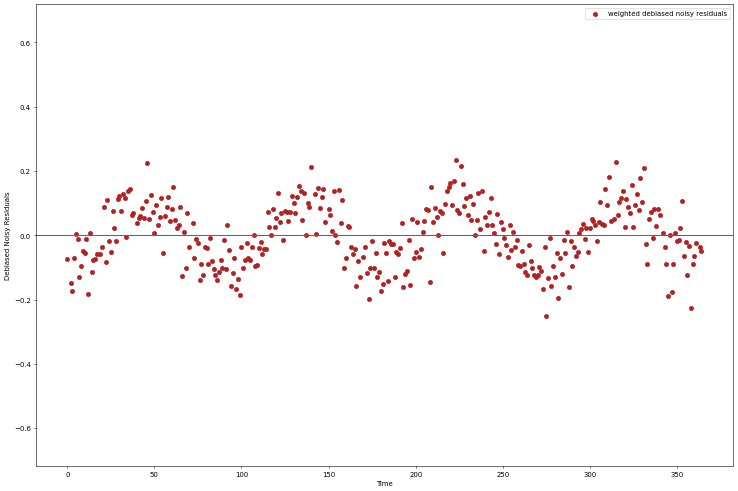

In [30]:
weighted_debiased = B_wls @ noisy_residuals

plt.scatter(xs, weighted_debiased, label="weighted debiased noisy residuals", color='firebrick')
lim = np.max(np.abs(residuals))
plt.ylim([-lim, lim])
xlim = plt.xlim()
plt.plot(xlim, [0, 0])
plt.xlim(xlim)
plt.ylabel("Debiased Noisy Residuals")
plt.xlabel("Time")
plt.legend()

Let's try the weighted least squares approach with the simulated residuals (not the temperature toy problem),

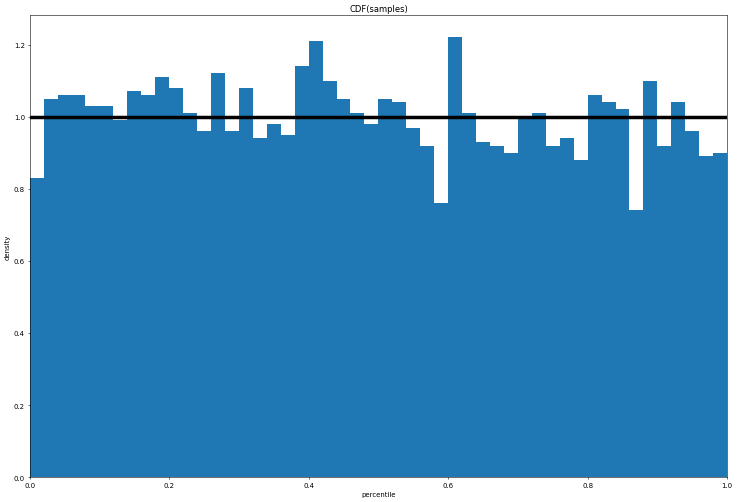

In [31]:
n = S.shape[0]
A_bias = np.ones((n, 1))
H_wls = weighted_hat_operator(A_bias, S)
B_wls = np.eye(n) - H_wls

wls_residuals = B_wls @ r
wls_cov = B_wls @ S @ B_wls.T
wls_df = np.trace(B_wls) # trace = sum of eigen values
reliability_diagram(wls_residuals, get_mvn_cdf(wls_cov, df=wls_df))

Looks like it checks out! Let's take a look at the RMSE values computed using Ordinary Least Squares (OLS) compared to Weighted Least Squares (WLS) and compare it to the same simulations where we didn't added those few very large noisy data points,

RMSE[no added noise]  :  0.08726804579589337
RMSE[added noise - OLS]:  0.8227217397094904
RMSE[added noise - WLS]:  0.8341374580970459


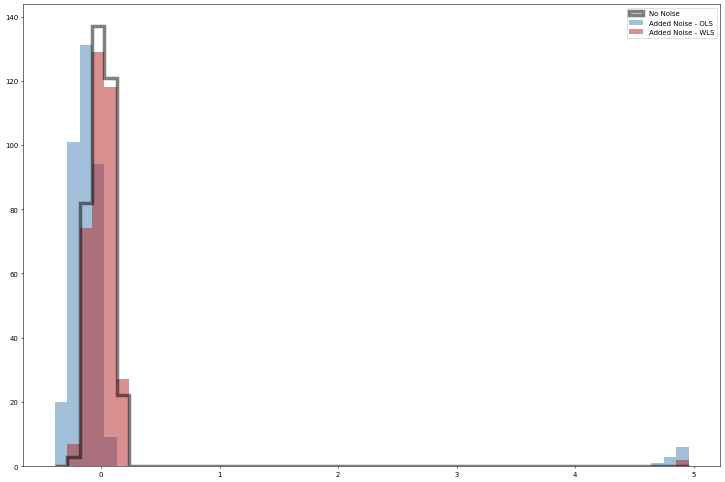

In [32]:
print("RMSE[no added noise]  : ", rmse(debiased))
print("RMSE[added noise - OLS]: ", rmse(debiased_noisy))
print("RMSE[added noise - WLS]: ", rmse(weighted_debiased))

_, bins = np.histogram(debiased_noisy, bins=51)
plt.hist(debiased, bins=bins, label="No Noise", alpha=0.5, color='black', histtype='step', lw=5)
plt.hist(debiased_noisy, bins=bins, label="Added Noise - OLS", alpha=0.5, color='steelblue')
plt.hist(weighted_debiased, bins=bins, label="Added Noise - WLS", alpha=0.5, color='firebrick')
plt.legend()

The averaged RMSE values with addeded noise are nearly 10x larger than the noise free situation! This RMSE is _very_ sensitive to large values. The other thing worth noting is that while the RMSE for OLS and WLS is pretty comparable, if you look at the distribution of residuals, the WLS approach leads to residuals which are closer in magnitude to the no noise scenario.

One approach would can help to equally weight the more/less noisy data, so RMSE isn't driven primarily by the large noisy data points, would be to normalize the data first. Effectively converting each residuals from an error in the same units as the measurements to an error in units of standard deviations. Here's what that would look like:

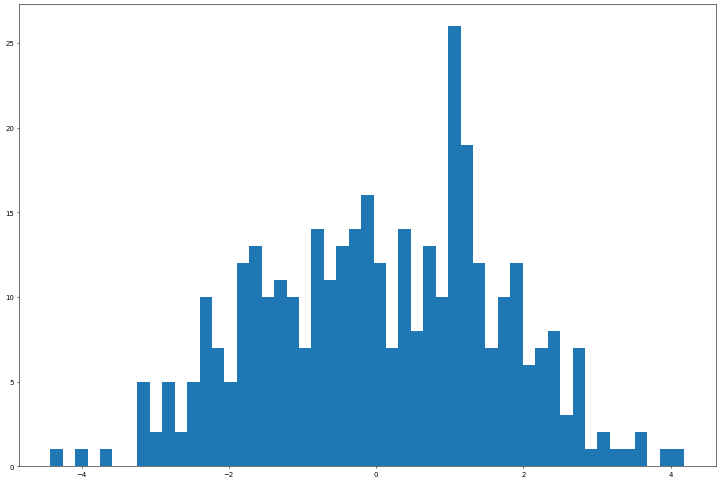

In [33]:
n = residuals.size

H_wls = weighted_hat_operator(A, simulated_noisy_cov)
B_wls = np.eye(n) - H_wls
resid_wls = B_wls @ noisy_residuals

L_wls = np.linalg.cholesky(B_wls @ simulated_noisy_cov @ B_wls.T)
normalized_resids = np.linalg.solve(L_wls, resid_wls)
_ = plt.hist(normalized_resids, bins=51)

Notice that we no longer see the really large residuals, those have been downweighted since their variance was so large ... but also it's harder to interpret the results which now have different units and depend on the scale of the covariance.

## Median verus Mean

Above we were comparing the root mean squared error and noticed that the RMSE was very sensitive to the noise characteristics of the data. In this example and RMSE computed using either ordinary of weighted debiasing was 10x the magnitude of the expected RMSE. The problem is that the mean function is very sensitive to outliers. Instead, take a look a the root _median_ squared error:

In [34]:
def root_median_squared_error(xs):
    return np.sqrt(np.median(np.square(xs)))

print("root_median_squared_error[no added noise]  : ", root_median_squared_error(debiased))
print("root_median_squared_error[added noise - OLS]: ", root_median_squared_error(debiased_noisy))
print("root_median_squared_error[added noise - WLS]: ", root_median_squared_error(weighted_debiased))

root_median_squared_error[no added noise]  :  0.06942080512232422
root_median_squared_error[added noise - OLS]:  0.144433174587015
root_median_squared_error[added noise - WLS]:  0.07177087381150356


Just using a median instead of a mean makes our error estimate using the weighted least squares approach **much** closer to the error without added noise.  This root median squared error is actually the same thing as the [median absolute error](https://en.wikipedia.org/wiki/Median_absolute_deviation),

In [35]:
def median_absolute_error(xs):
    return np.median(np.abs(xs))

print("median_absolute_error[no added noise]  : ", median_absolute_error(debiased))
print("median_absolute_error[added noise - OLS]: ", median_absolute_error(debiased_noisy))
print("median_absolute_error[added noise - WLS]: ", median_absolute_error(weighted_debiased))

median_absolute_error[no added noise]  :  0.06942080512232422
median_absolute_error[added noise - OLS]:  0.144433174587015
median_absolute_error[added noise - WLS]:  0.07177087381150356


### Key Point: When the model predictions or measurement noises are not the same for all the data points:
- you can use still use the debiasing techniques to remove known error sources in the evaluation data, but you should use weighted least squares.
- you can still compute aggregate error metrics, but you should probably use robust functions (median) instead of sensitive functions (mean) which are heavily influenced by the most uncertain measurements.

# Recap: Computing residuals and evaluating uncertainty in the presence of noisy data and uncertain predictions.

### Givens

Let's say you're given a model and some held out evaluation data, $y$. You can use the model to produce a prediction of the evaluation data,
$$
\hat{y} \sim \mathcal{N}\left(\mu, \Sigma\right).
$$
Your evaluation data may be imperfect, it may consist of some measurement noise, biases, or other error sources **which are not accounted for by your model**,
$$
y \sim \mathcal{N}\left(m, Q\right)
$$
Here $Q$ could be decomposed into a combination of measurement noise, $\mathcal{N}(0, Z)$, and some biases, $x \sim \mathcal{N}(0, X)$, remapped to the observations. We can then write,
$$
Q = A X A^T + Z
$$
Assuming $\Sigma$ and $Q$ are independent you can compute the error/residual distribution,
$$
\begin{align}
\mathbf{r} &= y - \hat{y} \\
  &\sim \mathcal{N}\left(m - \mu, \Sigma + Q\right)
\end{align}
$$

### Compute

We would then like to compute:

- A measure of the magnitude of the errors/residuals after having removed biases.
- A measure of the quality of the uncertainty estimate.

### Measuring The Magnitude Errors After Having Removed Biases

This can be done by setting up a weighted least squares problem (or Gaussian Process) which describes the residuals,

$$
\begin{align}
\mathbf{r} &= A x + \sim \mathcal{N}\left(0, \Sigma + Z\right)
\end{align}
$$
Notice that here the covariance is $\Sigma + Z$ _not_ $\Sigma + Q$. This is because $x$ captures the $A X A^T$ term in $Q$. We can use this system of equations to build the hat operator and debias operator,
$$
\begin{align}
H &= A \left(A^T \left(\Sigma + Z\right)^{-1} A\right)^{-1} A^T \left(\Sigma + Z\right)^{-1} \\
B &= I - H
\end{align}
$$
which we can then use to remove biases from the residuals,
$$
\begin{align}
\hat{r} &= B \left(m - \mu\right)
\end{align}
$$
At this point we can compute aggregations of the residuals to get things like the median absolute error.

### Measuring Quality of Uncertainty

Here we have two options, we can either,

1) Compute the chi squared percentile of $r$ relative to $\mathcal{N}\left(0, \Sigma + Q\right)$ with $n = |r|$ degrees of freedom.
2) compute the chi squared percentile of $\hat{r}$ relative to $\mathcal{N}\left(0, B(\Sigma + Q)B^T\right)$ with $n = \mbox{tr}(B)$ degrees of freedom.

When dealing with in sample residuals Option 1 might be more readily accesible. If performing out of sample evaluation (please do so!) then Option 2 is probably going to be easier.

After you've collected the chi squared percentiles for a large number of independent trials you can produce reliability diagrams to asses the quality of the model's uncertainty estimates.

# A Rough Sketch Using `albatross`

Here's an example of how to compute debiased residuals and chi squared percentiles for a given model and evaluation data using GPs in albatross:

```c
    // Givens
    RegressionDataset<T> eval_data = get_out_of_sample_eval_data();
    auto model = get_model_to_be_evaluated();

    // Compute the predicted mean and covariance
    JointDistribution prediction = model.predict(eval_data.features).joint();
    JointDistribution errors = eval_data.targets - prediction;

    // Build a covariance function which describes the sources of error
    // which are NOT accounted for already by the model and which are biasing the errors.
    BiasCovarianceFunction bias_cov_func;
    Eigen::MatrixXd bias_cov = bias_cov_func(eval_data.features);

    // Build a covariance function which describes the sources of error which are NOT
    // accounted for by the model, but which also don't bias the errors. This would include
    // measurement noise which is not accounted for by the eval_data.targets (and also not
    // accounted for by the model)
    EvaluationCovarianceFunction noise_cov_func;
    Eigen::MatrixXd noise_cov = noise_cov_func(eval_data.features);

    Eigen::MatrixXd total_variance =
        prediction.covariance + eval_data.targets.covariance + bias_cov + noise_cov;

    double chi2 = chi_squared_percentile(errors, total_variance);

    // Use the evaluation model to estimate, then remove biases from the evaluation data.
    Eigen::VectorXd information = total_variance.ldlt().solve(eval_data.targets.mean);
    Eigen::VectorXd bias_estimate = gp_mean_prediction(bias_cov, information);
    Eigen::VectorXd debiased_errors = errors.mean - bias_estimate;

    double rmse = root_mean_squared_error(debiased_errors);
```